In [17]:
import kagglehub

# Download brain tumor dataset
brain_tumor_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to brain tumor dataset files:", brain_tumor_path)

# Download lung xray dataset
lungxrays_path = kagglehub.dataset_download("samuel156/lungxrays-grayscale")
print("Path to lung xray dataset files:", lungxrays_path)

# Download lung xray dataset
skindisease_path = kagglehub.dataset_download("riyaelizashaju/skin-disease-classification-image-dataset")
print("Path to skin disease dataset files:", skindisease_path)

Path to brain tumor dataset files: /kaggle/input/brain-tumor-mri-dataset
Path to lung xray dataset files: /kaggle/input/lungxrays-grayscale
Path to skin disease dataset files: /kaggle/input/skin-disease-classification-image-dataset


In [18]:
import os

BASE_DIR = "/kaggle/input"

# Brain Tumor (MRI) Dataset
BRAIN_TUMOR_DIR = os.path.join(BASE_DIR, "brain-tumor-mri-dataset")
BRAIN_TRAIN_DIR = os.path.join(BRAIN_TUMOR_DIR, 'Training')
BRAIN_TEST_DIR = os.path.join(BRAIN_TUMOR_DIR, 'Testing')

# Lung Disease (X-ray) Dataset
LUNG_DIR = os.path.join(BASE_DIR, "lungxrays-grayscale/LungXRays-grayscale")
LUNG_TRAIN_DIR = os.path.join(LUNG_DIR, "train")
LUNG_TEST_DIR = os.path.join(LUNG_DIR, "test")
LUNG_VAL_DIR = os.path.join(LUNG_DIR, "val")

# Skin Disease Dataset
SKIN_DIR = os.path.join(BASE_DIR, "skin-disease-classification-image-dataset/Split_smol")
SKIN_TRAIN_DIR = os.path.join(SKIN_DIR, "train")
SKIN_TEST_DIR = os.path.join(SKIN_DIR, "val")

In [19]:
import torchvision.transforms as transforms

# 🔹 Transformations for Brain & Lung (Grayscale)
brain_lung_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),  # Convert to 1-channel grayscale
    transforms.RandomHorizontalFlip(),  # Augmentations
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for 1-channel
])

# 🔹 Transformations for Skin Disease (RGB)
skin_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Augmentations
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjusts color-based features
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Standard ImageNet normalization
])

In [22]:
# import os 
# from PIL import Image
# from torch.utils.data import Dataset, DataLoader

# # Custom Dataset Class
# class CustomDataset(Dataset):
#     def __init__(self, root_dir, transform, is_grayscale=True):
#         self.root_dir = root_dir
#         self.transform = transform
#         self.is_grayscale = is_grayscale  # Whether the dataset is grayscale (brain/lung) or RGB (skin)
#         self.classes = sorted(os.listdir(root_dir))
#         self.image_paths = []
#         self.labels = []

#         for label, class_name in enumerate(self.classes):
#             class_path = os.path.join(root_dir, class_name)
#             for img_name in os.listdir(class_path):
#                 self.image_paths.append(os.path.join(class_path, img_name))
#                 self.labels.append(label)

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         img_path = self.image_paths[idx]
#         label = self.labels[idx]

#         image = Image.open(img_path)

#         # 🌟 Convert to Grayscale Only for Brain & Lungs
#         if self.is_grayscale:
#             image = image.convert("L")  # Ensure 1 channel for grayscale images
#         else:
#             image = image.convert("RGB")  # Ensure 3 channels for RGB images

#         if self.transform:
#             image = self.transform(image)

#         return image, label

# # ✅ Create Datasets & DataLoaders
# brain_train_dataset = CustomDataset(BRAIN_TRAIN_DIR, transform=brain_lung_transform, is_grayscale=True)
# brain_test_dataset = CustomDataset(BRAIN_TEST_DIR, transform=brain_lung_transform, is_grayscale=True)

# lungs_train_dataset = CustomDataset(LUNG_TRAIN_DIR, transform=brain_lung_transform, is_grayscale=True)
# lungs_test_dataset = CustomDataset(LUNG_TEST_DIR, transform=brain_lung_transform, is_grayscale=True)

# skin_train_dataset = CustomDataset(SKIN_TRAIN_DIR, transform=skin_transform, is_grayscale=False)
# skin_test_dataset = CustomDataset(SKIN_TEST_DIR, transform=skin_transform, is_grayscale=False)

# # Create DataLoaders
# brain_train_loader = DataLoader(brain_train_dataset, batch_size=32, shuffle=True, num_workers=4)
# brain_test_loader = DataLoader(brain_test_dataset, batch_size=32, shuffle=False, num_workers=4)

# lungs_train_loader = DataLoader(lungs_train_dataset, batch_size=32, shuffle=True, num_workers=4)
# lungs_test_loader = DataLoader(lungs_test_dataset, batch_size=32, shuffle=False, num_workers=4)

# skin_train_loader = DataLoader(skin_train_dataset, batch_size=32, shuffle=True, num_workers=4)
# skin_test_loader = DataLoader(skin_test_dataset, batch_size=32, shuffle=False, num_workers=4)

import os 
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# Define label mappings for each classification task
BRAIN_TUMOR_LABELS = ["Glioma", "Meningioma", "No Tumor", "Pituitary"]
LUNG_XRAY_LABELS = ["Corona Virus Disease", "Normal", "Pneumonia", "Tuberculosis"]
SKIN_LABELS = [
    "Actinic keratosis", "Dermatofibroma", "Squamous cell carcinoma",
    "Atopic Dermatitis", "Melanocytic nevus", "Tinea Ringworm Candidiasis",
    "Benign keratosis", "Melanoma", "Vascular lesion"
]

# Create label-to-index mappings
BRAIN_LABEL_MAP = {label: idx for idx, label in enumerate(BRAIN_TUMOR_LABELS)}
LUNG_LABEL_MAP = {label: idx for idx, label in enumerate(LUNG_XRAY_LABELS)}
SKIN_LABEL_MAP = {label: idx for idx, label in enumerate(SKIN_LABELS)}

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform, label_map, is_grayscale=True):
        self.root_dir = root_dir
        self.transform = transform
        self.is_grayscale = is_grayscale
        self.label_map = label_map
        self.image_paths = []
        self.labels = []

        for class_name in self.label_map.keys():
            class_path = os.path.join(root_dir, class_name)
            if not os.path.exists(class_path) or not os.listdir(class_path):  # ✅ Skip empty folders
                print(f"Warning: Skipping empty or missing folder {class_path}")
                continue
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                if img_path.lower().endswith(('.*')):  # ✅ Only load image files
                    self.image_paths.append(img_path)
                    self.labels.append(self.label_map[class_name])

        if len(self.image_paths) == 0:
            raise ValueError(f"No images found in {root_dir}. Check dataset structure.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path)

        if self.is_grayscale:
            image = image.convert("L")
        else:
            image = image.convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


# ✅ Create Datasets & DataLoaders
brain_train_dataset = CustomDataset(BRAIN_TRAIN_DIR, transform=brain_lung_transform, label_map=BRAIN_LABEL_MAP, is_grayscale=True)
brain_test_dataset = CustomDataset(BRAIN_TEST_DIR, transform=brain_lung_transform, label_map=BRAIN_LABEL_MAP, is_grayscale=True)

lungs_train_dataset = CustomDataset(LUNG_TRAIN_DIR, transform=brain_lung_transform, label_map=LUNG_LABEL_MAP, is_grayscale=True)
lungs_test_dataset = CustomDataset(LUNG_TEST_DIR, transform=brain_lung_transform, label_map=LUNG_LABEL_MAP, is_grayscale=True)

skin_train_dataset = CustomDataset(SKIN_TRAIN_DIR, transform=skin_transform, label_map=SKIN_LABEL_MAP, is_grayscale=False)
skin_test_dataset = CustomDataset(SKIN_TEST_DIR, transform=skin_transform, label_map=SKIN_LABEL_MAP, is_grayscale=False)

# Create DataLoaders
brain_train_loader = DataLoader(brain_train_dataset, batch_size=32, shuffle=True, num_workers=4)
brain_test_loader = DataLoader(brain_test_dataset, batch_size=32, shuffle=False, num_workers=4)

lungs_train_loader = DataLoader(lungs_train_dataset, batch_size=32, shuffle=True, num_workers=4)
lungs_test_loader = DataLoader(lungs_test_dataset, batch_size=32, shuffle=False, num_workers=4)

skin_train_loader = DataLoader(skin_train_dataset, batch_size=32, shuffle=True, num_workers=4)
skin_test_loader = DataLoader(skin_test_dataset, batch_size=32, shuffle=False, num_workers=4)

# 🔥 Print Mappings for Verification
print("Brain Tumor Label Mapping:", BRAIN_LABEL_MAP)
print("Lung X-ray Label Mapping:", LUNG_LABEL_MAP)
print("Skin Disease Label Mapping:", SKIN_LABEL_MAP)


ValueError: No images found in /kaggle/input/brain-tumor-mri-dataset/Training. Check dataset structure.

In [23]:
import os
print(os.path.exists(BRAIN_TRAIN_DIR))
print(os.listdir(BRAIN_TRAIN_DIR))


True
['pituitary', 'notumor', 'meningioma', 'glioma']


In [5]:
import torch
import torch.nn as nn
import torchvision.models as models

class MultiHeadMedicalModel(nn.Module):
    def __init__(self, num_brain_classes=4, num_lung_classes=4, num_skin_classes=9):
        super(MultiHeadMedicalModel, self).__init__()

        # Load EfficientNet-B0 for grayscale (1-channel) images (brain & lung)
        self.backbone_gray = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        self.backbone_gray.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

        # Load EfficientNet-B0 for RGB (3-channel) images (skin diseases)
        self.backbone_rgb = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

        # Freeze initial layers of both backbones
        for param in self.backbone_gray.parameters():
            param.requires_grad = False
        for param in self.backbone_rgb.parameters():
            param.requires_grad = False

        # Unfreeze deeper layers for fine-tuning
        for param in self.backbone_gray.features[-3:].parameters():
            param.requires_grad = True
        for param in self.backbone_rgb.features[-3:].parameters():
            param.requires_grad = True

        # Separate classification heads
        self.brain_classifier = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(1280, num_brain_classes)  # Brain Tumor: 4 classes
        )

        self.lung_classifier = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(1280, num_lung_classes)  # Lung Disease: 4 classes
        )

        self.skin_classifier = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(1280, num_skin_classes)  # Skin Disease: 9 classes
        )

    def forward(self, x, task):
        if task in ["brain", "lung"]:  # Use grayscale backbone
            x = self.backbone_gray.features(x)
        elif task == "skin":  # Use RGB backbone
            x = self.backbone_rgb.features(x)
        else:
            raise ValueError("Invalid task. Choose 'brain', 'lung', or 'skin'.")

        x = self.backbone_gray.avgpool(x)  # Shared pooling
        x = torch.flatten(x, 1)

        if task == "brain":
            return self.brain_classifier(x)
        elif task == "lung":
            return self.lung_classifier(x)
        elif task == "skin":
            return self.skin_classifier(x)

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiHeadMedicalModel(num_brain_classes=4, num_lung_classes=4, num_skin_classes=9).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 179MB/s]


In [6]:
import torch.optim as optim

# Loss Function (CrossEntropy since labels are integers)
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam for adaptive learning)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # Import tqdm for progress bar

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10, device="cuda"):
    """
    Train a multi-task model using separate dataloaders for brain, lung, and skin disease classification.
    
    Parameters:
    - model: The multi-head classification model.
    - dataloaders: Dictionary containing 'brain', 'lung', and 'skin' dataloaders.
    - criterion: Loss function.
    - optimizer: Optimizer for training.
    - scheduler: Learning rate scheduler.
    - num_epochs: Number of epochs to train.
    - device: "cuda" or "cpu".
    """

    model.to(device)

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        epoch_loss = 0.0

        print(f"\nEpoch [{epoch+1}/{num_epochs}]")

        for task, dataloader in dataloaders.items():  # Loop through each task's dataloader
            task_loss = 0.0
            progress_bar = tqdm(dataloader, desc=f"Training {task}", leave=False)  # Progress bar

            for images, labels in progress_bar:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                
                # Forward pass (task-specific head)
                outputs = model(images, task=task)  
                
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                task_loss += loss.item()
                progress_bar.set_postfix(loss=loss.item())  # Update tqdm with loss

            epoch_loss += task_loss
            print(f"{task.capitalize()} Loss: {task_loss:.4f}")

        scheduler.step()  # Adjust learning rate

        print(f"Epoch [{epoch+1}/{num_epochs}] - Total Loss: {epoch_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

    print("Training complete.")

In [8]:
# Define dataloaders dictionary
dataloaders = {
    "brain": brain_train_loader,
    "lung": lungs_train_loader,
    "skin": skin_train_loader
}

# Train the model
train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=20, device=device)


Epoch [1/20]


Brain Loss: 58.9510


Lung Loss: 58.6536


Skin Loss: 30.7771
Epoch [1/20] - Total Loss: 148.3817, LR: 0.001000

Epoch [2/20]


Brain Loss: 33.0622


Lung Loss: 31.6946


Skin Loss: 14.3760
Epoch [2/20] - Total Loss: 79.1329, LR: 0.001000

Epoch [3/20]


Brain Loss: 26.3592


Lung Loss: 24.0108


Skin Loss: 10.4895
Epoch [3/20] - Total Loss: 60.8595, LR: 0.001000

Epoch [4/20]


Brain Loss: 19.3157


Lung Loss: 21.3452


Skin Loss: 10.0964
Epoch [4/20] - Total Loss: 50.7574, LR: 0.001000

Epoch [5/20]


Brain Loss: 14.4770


Lung Loss: 20.4976


Skin Loss: 9.2066
Epoch [5/20] - Total Loss: 44.1812, LR: 0.000500

Epoch [6/20]


Brain Loss: 8.7470


Lung Loss: 13.6535


Skin Loss: 5.7157
Epoch [6/20] - Total Loss: 28.1162, LR: 0.000500

Epoch [7/20]


Brain Loss: 7.6314


Lung Loss: 12.9855


Skin Loss: 4.4179
Epoch [7/20] - Total Loss: 25.0348, LR: 0.000500

Epoch [8/20]


Brain Loss: 6.2222


Lung Loss: 10.9586


Skin Loss: 3.1963
Epoch [8/20] - Total Loss: 20.3772, LR: 0.000500

Epoch [9/20]


Brain Loss: 7.1204


Lung Loss: 10.5503


Skin Loss: 3.8749
Epoch [9/20] - Total Loss: 21.5456, LR: 0.000500

Epoch [10/20]


Brain Loss: 7.3834


Lung Loss: 10.1189


Skin Loss: 3.8441
Epoch [10/20] - Total Loss: 21.3463, LR: 0.000250

Epoch [11/20]


Brain Loss: 4.7311


Lung Loss: 8.3344


Skin Loss: 2.5109
Epoch [11/20] - Total Loss: 15.5765, LR: 0.000250

Epoch [12/20]


Brain Loss: 3.2411


Lung Loss: 7.0744


Skin Loss: 2.6077
Epoch [12/20] - Total Loss: 12.9231, LR: 0.000250

Epoch [13/20]


Brain Loss: 3.2848


Lung Loss: 7.1056


Skin Loss: 1.8968
Epoch [13/20] - Total Loss: 12.2872, LR: 0.000250

Epoch [14/20]


Brain Loss: 3.7444


Lung Loss: 5.9498


Skin Loss: 1.9515
Epoch [14/20] - Total Loss: 11.6457, LR: 0.000250

Epoch [15/20]


Brain Loss: 2.4537


Lung Loss: 6.4247


Skin Loss: 2.4437
Epoch [15/20] - Total Loss: 11.3221, LR: 0.000125

Epoch [16/20]


Brain Loss: 2.2002


Lung Loss: 5.9150


Skin Loss: 1.3237
Epoch [16/20] - Total Loss: 9.4388, LR: 0.000125

Epoch [17/20]


Brain Loss: 1.8525


Lung Loss: 4.9633


Skin Loss: 1.0796
Epoch [17/20] - Total Loss: 7.8954, LR: 0.000125

Epoch [18/20]


Brain Loss: 2.3541


Lung Loss: 4.5453


Skin Loss: 1.5477
Epoch [18/20] - Total Loss: 8.4471, LR: 0.000125

Epoch [19/20]


Brain Loss: 1.5887


Lung Loss: 4.5237


Skin Loss: 1.3402
Epoch [19/20] - Total Loss: 7.4526, LR: 0.000125

Epoch [20/20]


Brain Loss: 1.2371


Lung Loss: 4.0566


Skin Loss: 1.7877
Epoch [20/20] - Total Loss: 7.0814, LR: 0.000063
Training complete.


In [9]:
def evaluate_multihead_model(model, test_loaders, device):
    model.eval()
    results = {}

    with torch.no_grad():
        for task, test_loader in test_loaders.items():
            correct = 0
            total = 0

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images, task)  # Ensure your model accepts a task argument
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

            accuracy = correct / total
            results[task] = accuracy
            print(f"{task} Test Accuracy: {accuracy:.4f}")

    return results

# Dictionary of test dataloaders
test_loaders = {
    "brain": brain_test_loader,
    "lung": lungs_test_loader,
    "skin": skin_test_loader
}

# Evaluate the multi-head model
evaluate_multihead_model(model, test_loaders, device)

brain Test Accuracy: 0.7582
lung Test Accuracy: 0.9791
skin Test Accuracy: 0.8287


{'brain': 0.7581998474446987,
 'lung': 0.9790769230769231,
 'skin': 0.8287292817679558}

Task: brain
Unique labels in y_true: [0 1 2 3]
Expected number of classes: 4
Shape of y_pred_probs: (1311, 4)


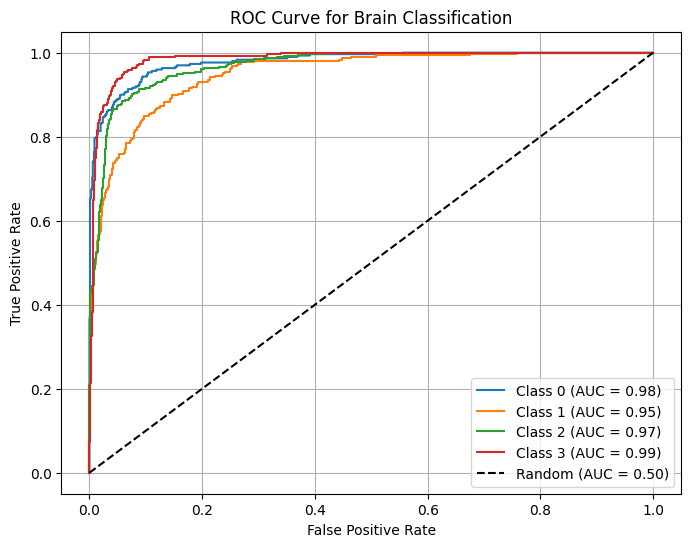

Brain Macro AUC Score: 0.9711
Task: lung
Unique labels in y_true: [0 1 2 3]
Expected number of classes: 4
Shape of y_pred_probs: (1625, 4)


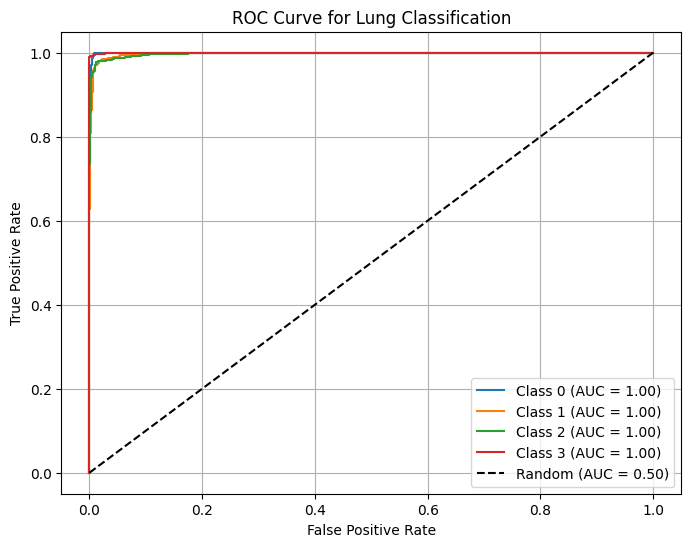

Lung Macro AUC Score: 0.9988
Task: skin
Unique labels in y_true: [0 1 2 3 4 5 6 7 8]
Expected number of classes: 9
Shape of y_pred_probs: (181, 9)


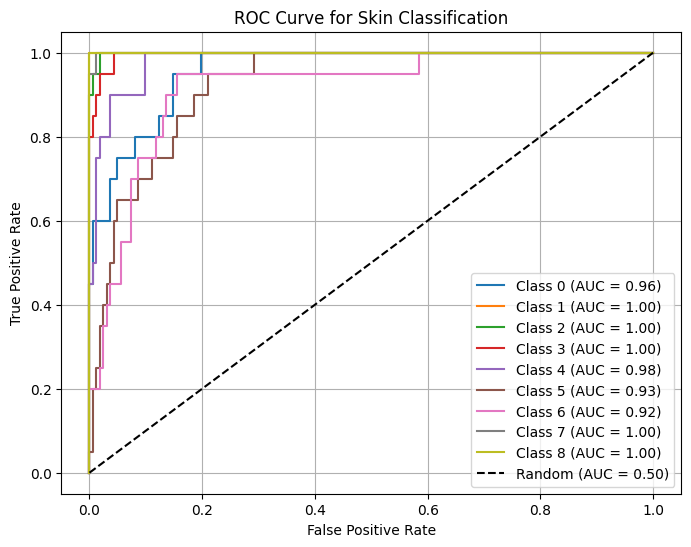

Skin Macro AUC Score: 0.9750


{'brain': 0.9710731109048937,
 'lung': 0.9987551810699643,
 'skin': 0.9750172532781227}

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import torch.nn.functional as F

# Function to calculate ROC AUC for multi-head model
def compute_multihead_roc_auc(model, test_loaders, num_classes_dict, device):
    model.eval()
    results = {}

    with torch.no_grad():
        for task, test_loader in test_loaders.items():
            y_true = []
            y_pred_probs = []

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images, task)  # Ensure model uses the correct head
                probs = F.softmax(outputs, dim=1)  # Convert logits to probabilities

                y_true.extend(labels.cpu().numpy())  # Store true labels
                y_pred_probs.extend(probs.cpu().numpy())  # Store predicted probabilities

            y_true = np.array(y_true)
            y_pred_probs = np.array(y_pred_probs)
            num_classes = num_classes_dict[task]  # Get the number of classes for this task

            print(f"Task: {task}")
            print(f"Unique labels in y_true: {np.unique(y_true)}")
            print(f"Expected number of classes: {num_classes}")
            print(f"Shape of y_pred_probs: {y_pred_probs.shape}")

            
            # Compute ROC Curve and AUC for each class
            plt.figure(figsize=(8, 6))
            for i in range(num_classes):
                fpr, tpr, _ = roc_curve(y_true == i, y_pred_probs[:, i])
                roc_auc = auc(fpr, tpr)

                plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

            # Plot the Random Guess Line
            plt.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random (AUC = 0.50)")

            # Final Plot Settings
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC Curve for {task.capitalize()} Classification")
            plt.legend(loc="lower right")
            plt.grid()
            plt.show()

            # Compute and Store Macro AUC Score
            macro_auc = roc_auc_score(y_true, y_pred_probs, multi_class="ovr")
            results[task] = macro_auc
            print(f"{task.capitalize()} Macro AUC Score: {macro_auc:.4f}")

    return results

# Dictionary of test dataloaders and number of classes
test_loaders = {
    "brain": brain_test_loader,
    "lung": lungs_test_loader,
    "skin": skin_test_loader
}

num_classes_dict = {
    "brain": 4,  # Adjust based on your dataset
    "lung": 4,  # Adjust based on your dataset
    "skin": 9   # Adjust based on your dataset
}

# Compute ROC AUC for multi-head model
compute_multihead_roc_auc(model, test_loaders, num_classes_dict, device)


In [11]:
test_loaders = {
    "brain": brain_test_loader,
    "lung": lungs_test_loader,
    "skin": skin_test_loader
}

for task, test_loader in test_loaders.items():
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())

    unique_classes = np.unique(y_true)
    print(f"Task: {task}, Unique Classes in Test Set: {unique_classes}")


Task: brain, Unique Classes in Test Set: [0 1 2 3]
Task: lung, Unique Classes in Test Set: [0 1 2 3]
Task: skin, Unique Classes in Test Set: [0 1 2 3 4 5 6 7 8]


In [12]:
import os

val_dir = "/kaggle/input/skin-disease-classification-image-dataset/Split_smol/val"

for class_name in os.listdir(val_dir):
    class_path = os.path.join(val_dir, class_name)
    if os.path.isdir(class_path):
        print(f"{class_name}: {len(os.listdir(class_path))} images")


Tinea Ringworm Candidiasis: 20 images
Melanoma: 20 images
Vascular lesion: 20 images
Melanocytic nevus: 20 images
Atopic Dermatitis: 21 images
Actinic keratosis: 20 images
Squamous cell carcinoma: 20 images
Benign keratosis: 20 images
Dermatofibroma: 20 images


In [14]:
torch.save(model.state_dict(), "Multi_head_medical_model.pth")